# Timeseries Forecasting of Cryptocurrency Prices

In this exploration, I make an attempt to train recurrent neural networks to predict the price of cryptocurrencies such as bitcoin.

## Importing Libraries and Reading in the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('./data/ETH USD Historical Data.csv')
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jan 11, 2018","1,229.10","1,245.90","1,331.80","1,109.80",364.76K,-1.51
1,"Jan 10, 2018","1,248.00","1,285.70","1,381.90","1,203.20",380.43K,-2.78
2,"Jan 09, 2018","1,283.70","1,129.40","1,299.00","1,119.10",296.90K,13.67
3,"Jan 08, 2018","1,129.30","1,115.90","1,225.00",968.12,439.43K,1.21
4,"Jan 07, 2018","1,115.80","1,004.30","1,116.00",999.50,199.83K,11.10


In [3]:
data.tail()

,Date,Price,Open,High,Low,Vol.,Change %
670,"Mar 12, 2016",12.92,11.95,13.45,11.95,0.24K,8.12
671,"Mar 11, 2016",11.95,11.75,11.95,11.75,0.05K,1.70
672,"Mar 10, 2016",11.75,11.20,11.85,11.07,0.00K,4.91
673,NaN,NaN,NaN,NaN,NaN,NaN,NaN
674,NaN,"Highest:1,381.90",Lowest:5.86,"Difference:1,376.04",Average:141.45,"Change %:10,874.11",NaN


In [4]:
data.dropna(axis=0, inplace=True)
data = data.iloc[::-1]

In [5]:
from pandas import datetime
data['Date'] = data['Date'].apply(lambda date: pd.to_datetime(date))

In [6]:
import locale
from locale import *
locale.setlocale(locale.LC_NUMERIC, '')
data['Price'] = data['Price'].apply(lambda x: atof(x))

In [7]:
data['Open'] = data['Open'].apply(lambda x: atof(x))
data['High'] = data['High'].apply(lambda x: atof(x))
data['Low'] = data['Low'].apply(lambda x: atof(x))

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 673 entries, 672 to 0
Data columns (total 7 columns):
Date        673 non-null datetime64[ns]
Price       673 non-null float64
Open        673 non-null float64
High        673 non-null float64
Low         673 non-null float64
Vol.        673 non-null object
Change %    673 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 42.1+ KB


## Visualizing prices for the whole dataset

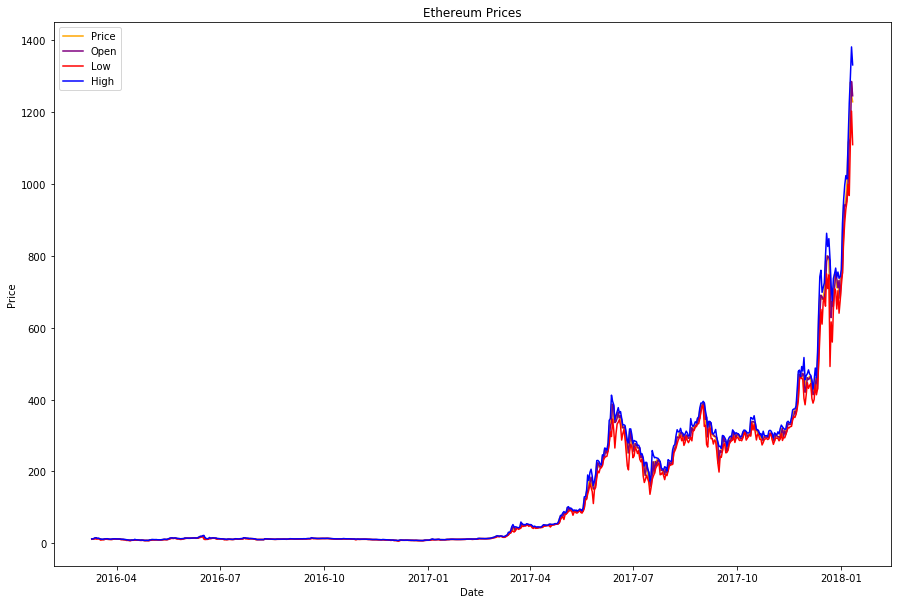

In [9]:
plt.plot(data['Date'], data['Price'], color = 'orange')
plt.plot(data['Date'], data['Open'], color='purple')
plt.plot(data['Date'], data['Low'], color='red')
plt.plot(data['Date'], data['High'], color='blue')
plt.title('Ethereum Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(15, 10)

## Using TensorFlow to Train RNNs

In [10]:
import tensorflow as tf

//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [11]:
data = data.set_index('Date')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 673 entries, 2016-03-10 to 2018-01-11
Data columns (total 6 columns):
Price       673 non-null float64
Open        673 non-null float64
High        673 non-null float64
Low         673 non-null float64
Vol.        673 non-null object
Change %    673 non-null float64
dtypes: float64(5), object(1)
memory usage: 36.8+ KB


### Scaling the Data
In order to train a neural network on this data, it is a good idea to scale it first.

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
price_data_scaled = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

### Creating a Dataset with Features

In [16]:
def create_dataset(timeseries, n_inputs=30):
    
    features = []
    targets = []
    
    for i in range(len(timeseries) - n_inputs):
        
        start = i
        end = start + n_inputs
        
        x = timeseries[start:end]
        y = timeseries[end]
        
        features.append(x)
        targets.append(y)
    
    return np.array(features), np.array(targets)

In [17]:
X, y = create_dataset(price_data_scaled, n_inputs=14)

In [18]:
X.shape

(659, 14, 1)

In [19]:
percent_training = 0.75
num_samples = X.shape[0]
num_train = int(percent_training * num_samples)

X_train, y_train = X[:num_train], y[:num_train]
X_test, y_test = X[num_train:], y[num_train:]

## Training the RNN Model

In [20]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

num_inputs = 14

model = Sequential()
model.add(LSTM(100, input_shape=(num_inputs, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

Using TensorFlow backend.


In [21]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          batch_size=1, epochs=100, callbacks=[early_stopping])

Train on 494 samples, validate on 165 samples
Epoch 1/100
494/494 [==============================] - 5s 10ms/step - loss: 5.2479e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0016 - val_mean_absolute_error: 0.0275
Epoch 2/100
494/494 [==============================] - 4s 9ms/step - loss: 1.9990e-04 - mean_absolute_error: 0.0077 - val_loss: 0.0012 - val_mean_absolute_error: 0.0240
Epoch 3/100
494/494 [==============================] - 4s 8ms/step - loss: 1.6157e-04 - mean_absolute_error: 0.0065 - val_loss: 0.0025 - val_mean_absolute_error: 0.0362
Epoch 4/100
494/494 [==============================] - 4s 8ms/step - loss: 1.4681e-04 - mean_absolute_error: 0.0063 - val_loss: 0.0022 - val_mean_absolute_error: 0.0315
Epoch 5/100
494/494 [==============================] - 4s 9ms/step - loss: 1.2864e-04 - mean_absolute_error: 0.0062 - val_loss: 9.2172e-04 - val_mean_absolute_error: 0.0188
Epoch 6/100
494/494 [==============================] - 4s 9ms/step - loss: 1.2213e-04 - mean_absolute_er

In [22]:
model.save('./models/ethereum_model.h5')

### Comparing Generated Predictions with Prices in Testing Set

In [23]:
pred = model.predict(X_test)

In [24]:
pred.shape

(165, 1)

In [25]:
results = scaler.inverse_transform(pred)

In [26]:
num_samples = pred.shape[0]
test_data_price = data.iloc[-num_samples:]['Price']

In [27]:
test_data_price_pred = pd.DataFrame({'Date': test_data_price.index, 
                                     'Price': test_data_price.values, 
                                     'Prediction': results[:, 0]})

In [28]:
test_data_price_pred

,Date,Prediction,Price
0,2017-07-31,194.534729,200.81
1,2017-08-01,196.390106,225.97
2,2017-08-02,211.408096,218.00
3,2017-08-03,215.902130,224.79
4,2017-08-04,221.318832,220.73
5,2017-08-05,221.464951,253.87
6,2017-08-06,238.798111,264.29
7,2017-08-07,253.944626,269.51
8,2017-08-08,264.245728,295.83
9,2017-08-09,283.001801,293.99


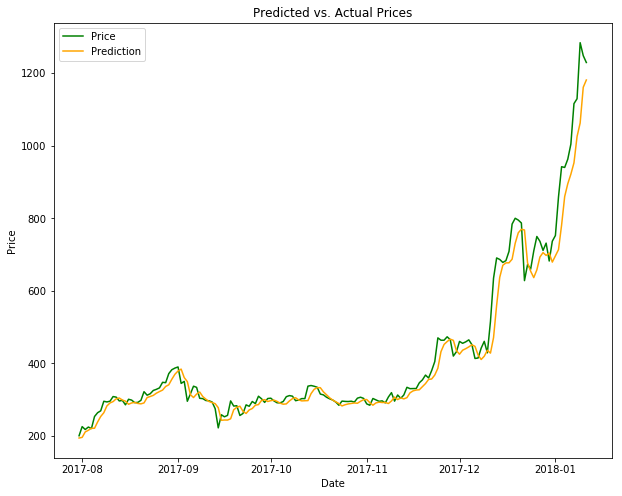

In [29]:
plt.plot(test_data_price_pred['Date'], test_data_price_pred['Price'], color='green')
plt.plot(test_data_price_pred['Date'], test_data_price_pred['Prediction'], color='orange')
plt.legend()
plt.title('Predicted vs. Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
fig = plt.gcf()
fig.set_size_inches(10, 8)